In [1]:
from pyhdf import SD
import numpy as np

from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import pickle

import pandas as pd

import datetime
import glob

In [2]:
def generate_list_of_days_split_by_weeks(START, END):
    
    df = pd.DataFrame()
    df['date'] = pd.date_range(START, END - datetime.timedelta(days=1), freq='d')
    df['day_of_week'] = df['date'].dt.dayofweek

    weeks = []
    week = []

    for a, b  in df.values:
        if b != 0:
            week.append(a)
        else:
            weeks.append(week)
            week = []
            week.append(a)

    weeks.append(week)
    
    return weeks

In [3]:
START = "2019-11-01"
END   = "2019-12-01"

START = datetime.datetime.strptime(START, "%Y-%m-%d")
END = datetime.datetime.strptime(END, "%Y-%m-%d")

weeks = generate_list_of_days_split_by_weeks(START, END)

In [4]:
KOLKATA_LAT = 22.5726
KOLKATA_LON = 88.3639

city = "KOLKATA"

In [5]:
def get_bounding_lat_lng(lat, lon):

    sn_data = np.genfromtxt('sn_bound_10deg.txt', 
                         skip_header = 7, 
                         skip_footer = 3)

    flag = False
    i = 0
    while(not flag):
        flag = lat >= sn_data[i, 4] and lat <= sn_data[i, 5] and lon >= sn_data[i, 2] and lon <= sn_data[i, 3]
        i += 1

    vertical   = sn_data[i-1, 0]
    horizontal = sn_data[i-1, 1]

    min_lon = sn_data[i-1, 2]
    max_lon = sn_data[i-1, 3]

    min_lat = sn_data[i-1, 4]
    max_lat = sn_data[i-1, 5]
    
    return min_lon, max_lon, min_lat, max_lat

In [6]:
min_lon, max_lon, min_lat, max_lat = get_bounding_lat_lng(KOLKATA_LAT, KOLKATA_LON)

In [7]:
import glob

BASE_NAME = "MCD19A2.A"
DIRECTORY = "../Downloads/Kolkata-Nov-2019/hdfs/"
SDS_NAME = "Optical_Depth_047"

GEN_PICKLE = True

In [8]:
from pyhdf import SD

longitude, latitude = np.meshgrid(np.linspace(min_lon, max_lon, 1200),np.linspace(min_lat,max_lat, 1200))
scale_factor = 0

def get_hdf_eos_information(FILE_NAME, date_time):
    
    name = FILE_NAME.split('/')[-1]
    
    hdf = SD.SD(FILE_NAME)
    
    sds = hdf.select(SDS_NAME)

    attributes = sds.attributes()
    
    global scale_factor
    scale_factor = attributes['scale_factor']
    
    sds_range = sds.getrange()
    min_range = min(sds_range)
    max_range = max(sds_range)

    data = sds.get()

    fv = attributes['_FillValue']
    data = data.astype(float)
    data[data == fv] = np.nan

    data = np.nanmean(data, axis=0)

    valid_data = data.ravel()
    valid_data = [x for x in valid_data if x>=min_range]
    valid_data = [x for x in valid_data if x<=max_range]
    valid_data = np.asarray(valid_data)

    valid_data = valid_data*scale_factor
    average = sum(valid_data)/len(valid_data)
    stdev = np.std(valid_data)
    
    return {
        "date_time": date_time,
        "path": FILE_NAME,
        "name": name,
        "res_type": 1,
        "sds_name": SDS_NAME,
        "lat_range": (min_lat, max_lat),
        "lon_range": (min_lon, max_lon),
        "data": data,
        "average": average,
        "stdev": stdev,
        "sds": sds,
        "latitude": latitude,
        "longitude": longitude,
        "hdf": hdf,
        "scale_factor": scale_factor
    }

In [9]:
pkl_obj = pickle.load(open("kolkata_geodata.pkl", "rb"))
KOLKATA_B_MIN_LON, KOLKATA_B_MAX_LON = pkl_obj['min_lon'], pkl_obj['max_lon']
KOLKATA_B_MIN_LAT, KOLKATA_B_MAX_LAT = pkl_obj['min_lat'], pkl_obj['max_lat']
boundary = pkl_obj['boundary']
mask = pkl_obj['kolkata_mask']

def plot_hdf_Kolkata(data, START, END):    
    
    data = np.ma.masked_array(data, np.isnan(data))
    date_str_format = START.strftime("%YD%j") + "-" + END.strftime("%YD%j")

    plt.figure(figsize=(20, 10))

    pad = 0.01

    m = Basemap(projection='cyl', resolution='l', llcrnrlat=KOLKATA_B_MIN_LAT-pad, urcrnrlat=KOLKATA_B_MAX_LAT+pad, llcrnrlon=KOLKATA_B_MIN_LON-pad, urcrnrlon=KOLKATA_B_MAX_LON+pad , suppress_ticks=True)

    m.readshapefile("../Municipal_Spatial_Data/Kolkata/Kolkata",'Kolkata', linewidth=1)

    m.drawparallels(np.arange(-90., 120., 0.05), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 0.05), labels=[0, 0, 0, 1])
    x, y = m(longitude[mask], latitude[mask])

    sc = m.scatter(x, y, c=data[mask]*0.001, s=1650, cmap=plt.cm.jet,
                        edgecolors='white', linewidth=0, marker='s')

    plt.clim(0, 5)
    
    cb = m.colorbar()
    cb.set_label('AOD')

    plotTitle = START.strftime("%Y-%V")
    plt.title('{0}\n {1}\n Kolkata, India\n {2}'.format(plotTitle, SDS_NAME, date_str_format))
    fig = plt.gcf()

    plt.show()

    pngfile = 'images/{0}.png'.format(plotTitle)
    fig.savefig(pngfile, bbox_inches="tight", dpi=400)

In [10]:
import pickle

file_name = city.lower() + "-" + START.strftime("%YD%j") + "-" + END.strftime("%YD%j")

if GEN_PICKLE:
    
    month_data = []

    for week in weeks:
        week_data = []
        for day in week:
            FILE_NAME = BASE_NAME + day.strftime('%Y%j')
            FILE_NAME = glob.glob(DIRECTORY + FILE_NAME + "*")[0]
            obj = get_hdf_eos_information(FILE_NAME, day)
            week_data.append(obj['data'])
        month_data.append([np.nanmean(np.array(week_data), axis=0).round(2), week[0], week[-1]])

    month_data = np.array(month_data)
    
    pickle.dump(month_data, open(f"pkls/{file_name}.pkl", "wb"))
    
else:
    month_data = pickle.load(open(f"pkls/{file_name}.pkl", "rb"))

<ipython-input-8-b26ba1104183>:29: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data, axis=0)
<ipython-input-10-0445ff739355>:16: RuntimeWarning: Mean of empty slice
  month_data.append([np.nanmean(np.array(week_data), axis=0).round(2), week[0], week[-1]])
<ipython-input-10-0445ff739355>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  month_data = np.array(month_data)


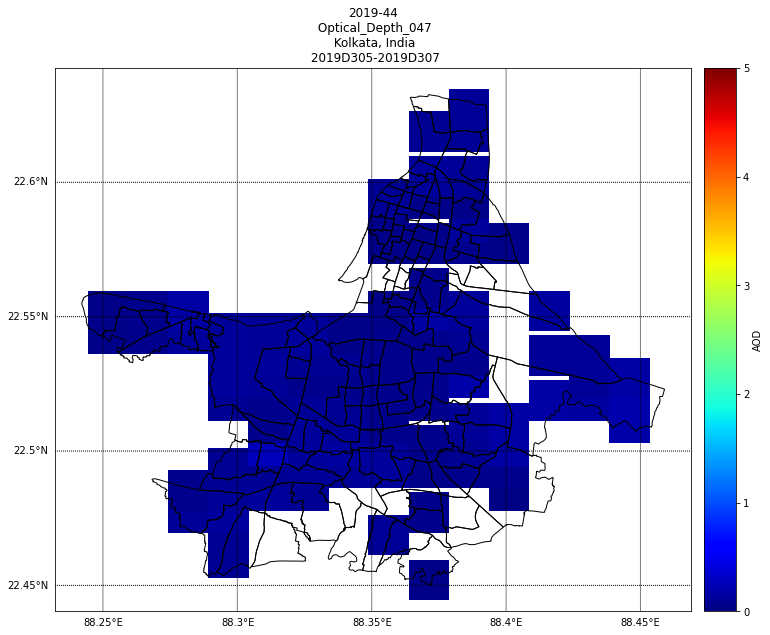

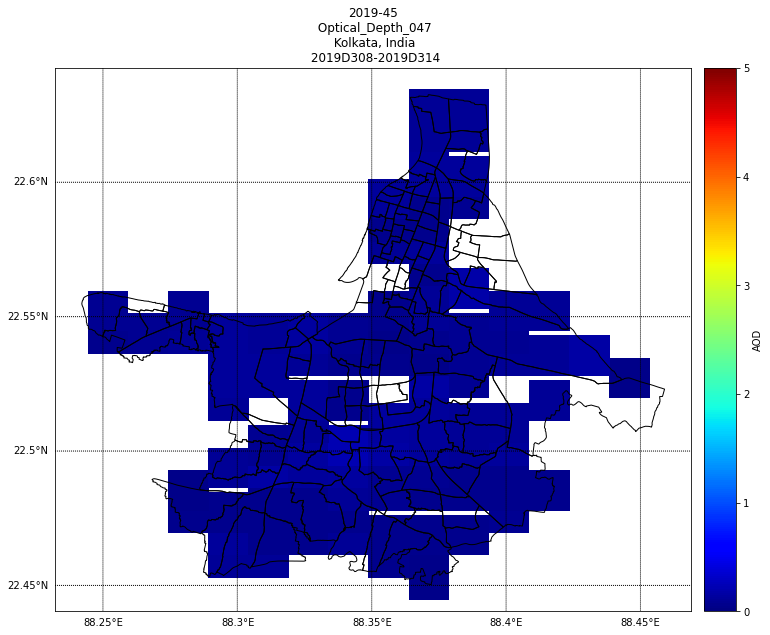

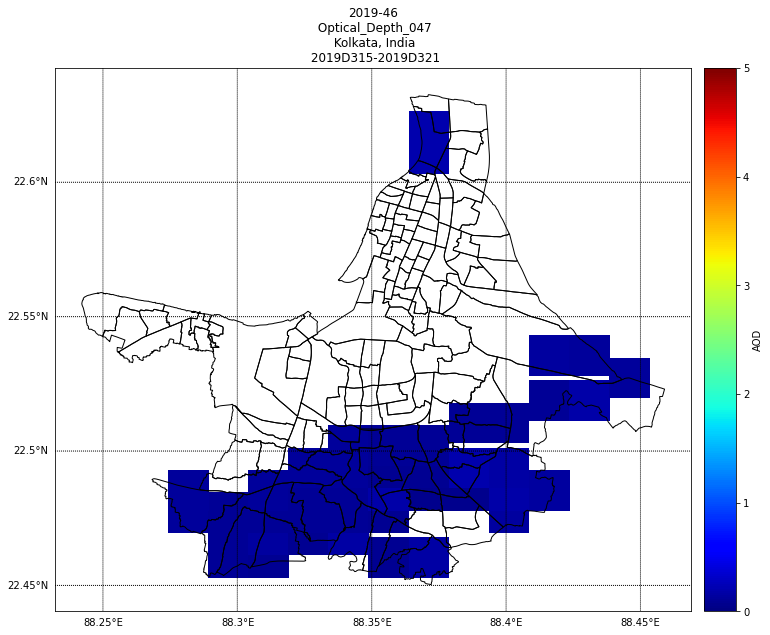

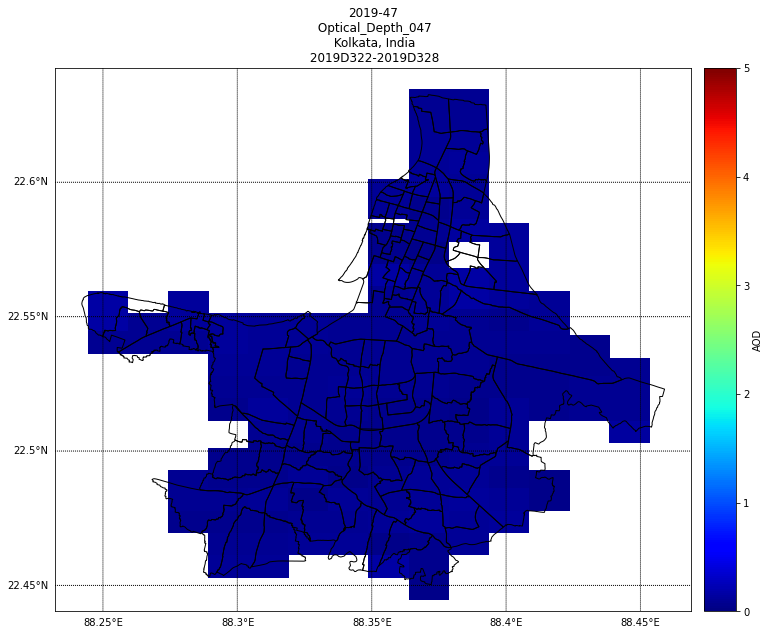

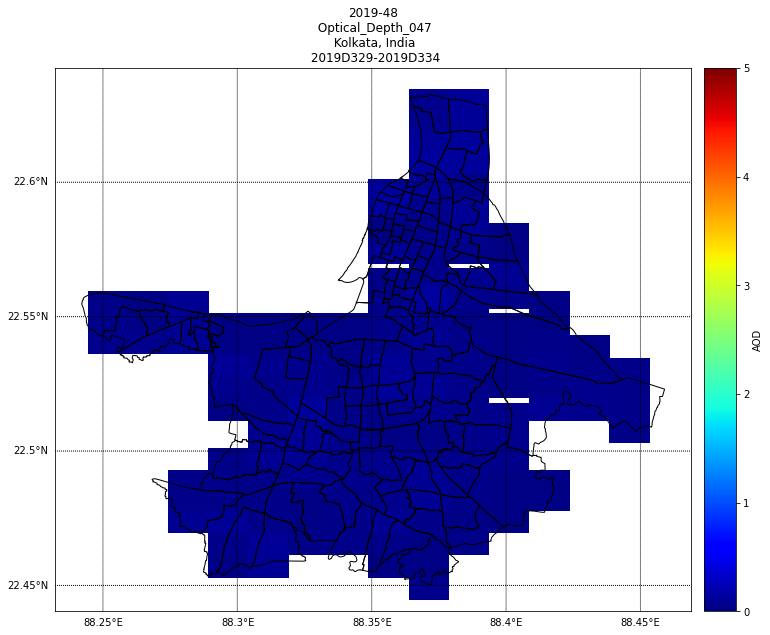

In [11]:
for i in range(len(weeks)):
    plot_hdf_Kolkata(month_data[i][0], month_data[i][1], month_data[i][2])